In [112]:
import collections

import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [113]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [114]:
data_path = '../data/p1ch7/'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
    )
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
    )

In [115]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [116]:
conv = nn.Conv2d(3, 16, 3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [117]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [118]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


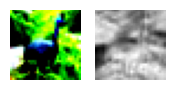

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(2, 4))

axs[0].imshow(img.permute(1, 2, 0)) # out image is darker because of normalization
axs[0].axis('off')

axs[1].imshow(output[0, 0].detach(), cmap='gray')
axs[1].axis('off');

In [37]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [38]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1./9.)

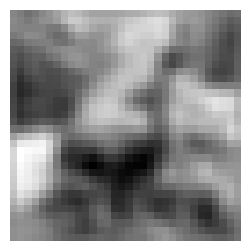

In [39]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(3, 3))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.axis('off');

In [40]:
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1., 0., 1.],
                                   [-1., 0., 1.],
                                   [-1., 0., 1.]])
    
    conv.bias.zero_()

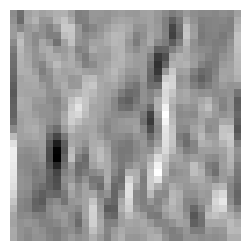

In [41]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(3, 3))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.axis('off');

In [42]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [43]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(), 
    nn.Linear(512, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [44]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [45]:
model(img.unsqueeze(0))

tensor([[ 0.0064, -0.0160]], grad_fn=<AddmmBackward0>)

In [46]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, img):
        out = self.pool1(self.act1(self.conv1(img)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)

        return out

In [47]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, img):
        out = F.max_pool2d(torch.tanh(self.conv1(img)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

In [48]:
model = ConvNet()
output = model(img.unsqueeze(0))
output

tensor([[ 0.0077, -0.0080]], grad_fn=<AddmmBackward0>)

In [49]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            out = model(imgs)
            loss = loss_fn(out, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch ==1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch: {epoch}, Training Loss: {loss_train/len(train_loader)}')

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, shuffle=True, batch_size=64)

model = ConvNet()
optimizer = optim.SGD(model.parameters(), 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(10, optimizer, model, loss_fn, train_loader)

2024-02-22 22:24:05.104441 Epoch: 1, Training Loss: 0.5772960058822754
2024-02-22 22:25:50.140455 Epoch: 10, Training Loss: 0.3507253421340019


In [51]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0 

        with torch.no_grad():
            for imgs, labels in loader:
                out = model(imgs)
                _, predicted = torch.max(out, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print(f'{name}: {correct/total:.3f}') 

validate(model, train_loader, val_loader)

train: 0.847
val: 0.842


In [52]:
torch.save(model.state_dict(), '../data/p1ch8/bird_vs_planes.pt')

In [53]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load('../data/p1ch8/bird_vs_planes.pt'))

<All keys matched successfully>

In [54]:
device = (torch.device('mps') if torch.backends.mps.is_available()
            else torch.device('cpu') )
device

device(type='mps')

In [55]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            out = model(imgs)
            loss = loss_fn(out, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch ==1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch: {epoch}, Training Loss: {loss_train/len(train_loader)}')

In [56]:
train_loader = torch.utils.data.DataLoader(cifar2, shuffle=True, batch_size=64)

model = ConvNet().to(device=device)
optimizer = optim.SGD(model.parameters(), 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader)

2024-02-22 22:25:52.577464 Epoch: 1, Training Loss: 0.5919078677702861
2024-02-22 22:25:59.084114 Epoch: 10, Training Loss: 0.332941460096912
2024-02-22 22:26:05.701055 Epoch: 20, Training Loss: 0.2957310652372184
2024-02-22 22:26:12.193012 Epoch: 30, Training Loss: 0.27019992508706014
2024-02-22 22:26:18.810928 Epoch: 40, Training Loss: 0.24895288515242803
2024-02-22 22:26:25.284458 Epoch: 50, Training Loss: 0.23132044874179136
2024-02-22 22:26:31.833233 Epoch: 60, Training Loss: 0.21430483308567363
2024-02-22 22:26:38.304146 Epoch: 70, Training Loss: 0.19812926393785293
2024-02-22 22:26:44.769192 Epoch: 80, Training Loss: 0.1861594908508905
2024-02-22 22:26:51.535225 Epoch: 90, Training Loss: 0.1678439846179288
2024-02-22 22:26:58.052429 Epoch: 100, Training Loss: 0.15525320850929636


In [57]:
torch.save(model.state_dict(), '../data/p1ch8/bird_vs_planes_gpu.pt')

In [58]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load('../data/p1ch8/bird_vs_planes_gpu.pt', map_location=device))

<All keys matched successfully>

In [59]:
all_acc_dict = collections.OrderedDict()

In [60]:
def validate(model, train_loader, val_loader):
    acc_dict = {}

    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outs = model(imgs)
                _, predicted = torch.max(outs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

            acc_dict[name] = correct/total
            print(f'Accuracy {name}: {correct/total:.2f}')
    
    return acc_dict

all_acc_dict['baseline'] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.88


In [61]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        x = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        x = x.view(-1, 16*8*8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [62]:
class NetWidth(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chl//2*8*8, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, self.n_chl//2*8*8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [111]:
model = NetWidth().to(device=device)
p_numel = [p.numel() for p in model.parameters()]
sum(p_numel), p_numel

(136978, [864, 32, 4608, 16, 131072, 128, 256, 2])

In [63]:
model = NetWidth().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2024-02-22 22:26:59.532557 Epoch: 1, Training Loss: 0.5449151599862773
2024-02-22 22:27:07.440471 Epoch: 10, Training Loss: 0.31462951972606074
2024-02-22 22:27:16.266854 Epoch: 20, Training Loss: 0.2686987490790665
2024-02-22 22:27:25.877169 Epoch: 30, Training Loss: 0.24219324335360984
2024-02-22 22:27:34.887733 Epoch: 40, Training Loss: 0.21432294255229317
2024-02-22 22:27:43.674210 Epoch: 50, Training Loss: 0.19201517351873362
2024-02-22 22:27:52.507820 Epoch: 60, Training Loss: 0.16965463861917993
2024-02-22 22:28:01.256813 Epoch: 70, Training Loss: 0.15019063359707785
2024-02-22 22:28:10.051680 Epoch: 80, Training Loss: 0.13089677677222877
2024-02-22 22:28:18.975773 Epoch: 90, Training Loss: 0.10879683855232919
2024-02-22 22:28:27.752277 Epoch: 100, Training Loss: 0.09190000448921684
Accuracy train: 0.97
Accuracy val: 0.89


In [64]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
 
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm # pytorch optims come with weight_decay so we don't need to do this
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [65]:
model = ConvNet().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

all_acc_dict['l2_reg'] = validate(model, train_loader, val_loader)

2024-02-22 22:28:30.415647 Epoch 1, Training loss 0.5871296995764326
2024-02-22 22:28:41.487921 Epoch 10, Training loss 0.3576106181380096
2024-02-22 22:28:53.289919 Epoch 20, Training loss 0.32170760745455507
2024-02-22 22:29:05.067123 Epoch 30, Training loss 0.2949266143285545
2024-02-22 22:29:16.862866 Epoch 40, Training loss 0.27398275731095845
2024-02-22 22:29:28.911335 Epoch 50, Training loss 0.2563651980962723
2024-02-22 22:29:40.761361 Epoch 60, Training loss 0.24566468145627124
2024-02-22 22:29:52.612443 Epoch 70, Training loss 0.2320577706311159
2024-02-22 22:30:04.444474 Epoch 80, Training loss 0.22224137419538134
2024-02-22 22:30:16.269484 Epoch 90, Training loss 0.21477875137215208
2024-02-22 22:30:28.290761 Epoch 100, Training loss 0.20572106222248382
Accuracy train: 0.93
Accuracy val: 0.90


In [74]:
class NetDropout(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=3, padding=1)
        self.drop1 = nn.Dropout2d(p=0.4)
        self.drop2 = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(n_chl//2*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = self.drop1(x)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = self.drop2(x)
        x = x.view(-1, self.n_chl//2*8*8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [75]:
model = NetDropout(n_chl=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

model.eval()
all_acc_dict['dropout'] = validate(model, train_loader, val_loader)

2024-02-22 22:37:24.160601 Epoch: 1, Training Loss: 0.5496878517661125
2024-02-22 22:37:33.489533 Epoch: 10, Training Loss: 0.37477678905247125
2024-02-22 22:37:43.458400 Epoch: 20, Training Loss: 0.3463282560466961
2024-02-22 22:37:53.430156 Epoch: 30, Training Loss: 0.3273184625016656
2024-02-22 22:38:03.223055 Epoch: 40, Training Loss: 0.3104323052866444
2024-02-22 22:38:12.916699 Epoch: 50, Training Loss: 0.2963821258704374
2024-02-22 22:38:22.730509 Epoch: 60, Training Loss: 0.2844595412729652
2024-02-22 22:38:32.441208 Epoch: 70, Training Loss: 0.26658063054464426
2024-02-22 22:38:42.110327 Epoch: 80, Training Loss: 0.25935590067866504
2024-02-22 22:38:51.793963 Epoch: 90, Training Loss: 0.2514075774960457
2024-02-22 22:39:01.470669 Epoch: 100, Training Loss: 0.23555298942099712
Accuracy train: 0.92
Accuracy val: 0.90


In [76]:
model = NetDropout()
model.train()

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout2d(p=0.4, inplace=False)
  (drop2): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [77]:
model.eval() # we can't see below but dropout will be turned off during eval

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout2d(p=0.4, inplace=False)
  (drop2): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [86]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chl)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chl//2)
        self.fc1 = nn.Linear(n_chl//2*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(torch.tanh(x), 2)

        x = self.conv2_batchnorm(self.conv2(x))
        x = F.max_pool2d(torch.tanh(x), 2)

        x = x.view(-1, self.n_chl//2*8*8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x


In [87]:
model = NetBatchNorm(n_chl=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

model.eval()
all_acc_dict['batch_norm'] = validate(model, train_loader, val_loader)

2024-02-22 22:44:56.563451 Epoch: 1, Training Loss: 0.47088500895317953
2024-02-22 22:45:05.793585 Epoch: 10, Training Loss: 0.267878041715379
2024-02-22 22:45:15.588037 Epoch: 20, Training Loss: 0.21563760822366
2024-02-22 22:45:26.110341 Epoch: 30, Training Loss: 0.175705256925267
2024-02-22 22:45:36.159906 Epoch: 40, Training Loss: 0.1384810528889963
2024-02-22 22:45:45.823396 Epoch: 50, Training Loss: 0.10296995145310263
2024-02-22 22:45:55.759597 Epoch: 60, Training Loss: 0.07827183875925602
2024-02-22 22:46:05.478568 Epoch: 70, Training Loss: 0.055473515668966966
2024-02-22 22:46:15.122181 Epoch: 80, Training Loss: 0.0407787021071573
2024-02-22 22:46:24.890288 Epoch: 90, Training Loss: 0.02811072162014379
2024-02-22 22:46:34.610547 Epoch: 100, Training Loss: 0.02057566304519108
Accuracy train: 1.00
Accuracy val: 0.89


In [93]:
class NetDepth(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chl//2, n_chl//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chl//2*4*4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv3(x)), 2)

        x = x.view(-1, self.n_chl//2*4*4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [94]:
model = NetDepth(n_chl=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader,
)

model.eval()
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2024-02-22 23:08:17.660864 Epoch: 1, Training Loss: 0.6863070927607785
2024-02-22 23:08:27.028527 Epoch: 10, Training Loss: 0.3477553095977018
2024-02-22 23:08:38.226202 Epoch: 20, Training Loss: 0.3018490527845492
2024-02-22 23:08:48.627476 Epoch: 30, Training Loss: 0.27377184546866995
2024-02-22 23:08:58.979504 Epoch: 40, Training Loss: 0.24582108817282755
2024-02-22 23:09:09.038995 Epoch: 50, Training Loss: 0.22149681570423638
2024-02-22 23:09:19.227972 Epoch: 60, Training Loss: 0.19538701482259543
2024-02-22 23:09:29.220077 Epoch: 70, Training Loss: 0.1635103155710515
2024-02-22 23:09:39.145193 Epoch: 80, Training Loss: 0.1417828198688425
2024-02-22 23:09:49.164295 Epoch: 90, Training Loss: 0.11541883379315875
2024-02-22 23:09:59.067356 Epoch: 100, Training Loss: 0.09415764107730738
Accuracy train: 0.87
Accuracy val: 0.83


In [95]:
class NetRes(nn.Module):
    def __init__(self, n_chl=32):
        super().__init__()
        self.n_chl = n_chl
        self.conv1 = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chl, n_chl//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chl//2, n_chl//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chl//2*4*4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), 2)
        x1 = x
        x = F.max_pool2d(torch.relu(self.conv3(x))+x1, 2)

        x = x.view(-1, self.n_chl//2*4*4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [96]:
model = NetRes(n_chl=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader,
)

model.eval()
all_acc_dict["resnet"] = validate(model, train_loader, val_loader)

2024-02-22 23:11:23.218976 Epoch: 1, Training Loss: 0.6068384383514429
2024-02-22 23:11:33.006141 Epoch: 10, Training Loss: 0.3183202324968994
2024-02-22 23:11:42.907998 Epoch: 20, Training Loss: 0.26639070974034107
2024-02-22 23:11:52.779951 Epoch: 30, Training Loss: 0.23474942987701694
2024-02-22 23:12:02.764295 Epoch: 40, Training Loss: 0.20737476257761572
2024-02-22 23:12:12.709952 Epoch: 50, Training Loss: 0.17903301803169736
2024-02-22 23:12:22.643713 Epoch: 60, Training Loss: 0.15936517421227353
2024-02-22 23:12:32.696437 Epoch: 70, Training Loss: 0.13244268287471525
2024-02-22 23:12:42.763512 Epoch: 80, Training Loss: 0.11463800655191492
2024-02-22 23:12:52.693668 Epoch: 90, Training Loss: 0.09140184846155014
2024-02-22 23:13:02.740803 Epoch: 100, Training Loss: 0.07264784022358953
Accuracy train: 0.74
Accuracy val: 0.73


In [97]:
class ResBloc(nn.Module):
    def __init__(self, n_chl):
        super().__init__()
        self.n_chl = n_chl
        self.conv = nn.Conv2d(n_chl, n_chl, kernel_size=3, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(num_features=n_chl)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.norm.weight, 0.5)
        torch.nn.init.zeros_(self.norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = torch.relu(out)

        return out + x

In [106]:
class NetResDeep(nn.Module):
    def __init__(self, n_chl=32, n_blocks=10):
        super().__init__()
        self.n_chl = n_chl
        self.conv = nn.Conv2d(3, n_chl, kernel_size=3, padding=1)
        self.resblock = nn.Sequential(*(n_blocks*[ResBloc(n_chl)]))
        self.fc1 = nn.Linear(n_chl*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv(x)), 2)
        x = self.resblock(x)
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, self.n_chl*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [107]:
model = NetResDeep(n_chl=32, n_blocks=100).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


model.train()
training_loop(
    100,
    optimizer,
    model,
    loss_fn,
    train_loader
)

model.eval()
all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)


2024-02-22 23:33:52.834274 Epoch: 1, Training Loss: 4.1302849086606575
2024-02-22 23:36:28.299461 Epoch: 10, Training Loss: 0.3906219269439673
2024-02-22 23:39:18.632970 Epoch: 20, Training Loss: 0.3281611849547951
2024-02-22 23:42:08.824169 Epoch: 30, Training Loss: 0.27019470526724104
2024-02-22 23:44:57.432738 Epoch: 40, Training Loss: 0.2431483787431079
2024-02-22 23:47:45.462773 Epoch: 50, Training Loss: 0.21156906317563573
2024-02-22 23:50:33.395983 Epoch: 60, Training Loss: 0.1870930713785302
2024-02-22 23:53:21.352367 Epoch: 70, Training Loss: 0.16804969590750468
2024-02-22 23:56:09.467245 Epoch: 80, Training Loss: 0.1584037903482747
2024-02-22 23:59:03.022744 Epoch: 90, Training Loss: 0.13030772863822
2024-02-23 00:01:51.308885 Epoch: 100, Training Loss: 0.1172305754724012
Accuracy train: 0.80
Accuracy val: 0.81


In [110]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9387, 'val': 0.881}),
             ('width', {'train': 0.9698, 'val': 0.891}),
             ('l2_reg', {'train': 0.9343, 'val': 0.9}),
             ('dropout', {'train': 0.9234, 'val': 0.8985}),
             ('batch_norm', {'train': 0.9975, 'val': 0.8855}),
             ('depth', {'train': 0.8653, 'val': 0.832}),
             ('resnet', {'train': 0.7433, 'val': 0.7315}),
             ('res_deep', {'train': 0.7969, 'val': 0.811})])

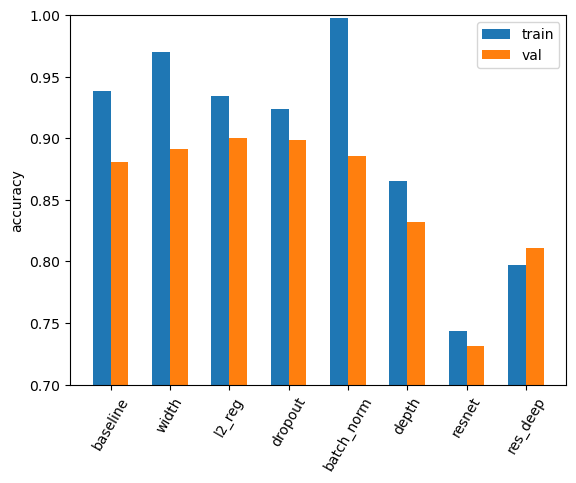

In [109]:
import numpy as np

trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()